### Student Activity: Financial Forecasting Part I

This program executes a single simulation of stock price trajectory over the next `252 * 3` trading days (or 3 years of trading) for `TSLA` stock, based on a normal probability distribution of historical daily returns derived from the sample mean and standard deviation.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi

%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Assets
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NASDAQ',
     'id': 'bb05f61a-daf9-4fff-9e26-e0adaf23fbb0',
     'marginable': True,
     'name': 'HBT Financial, Inc. Common Stock',
     'shortable': True,
     'status': 'active',
     'symbol': 'HBT',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'ARCA',
     'id': '38b93a03-cd62-4158-acfc-78b0ef46da46',
     'marginable': True,
     'name': 'Franklin FTSE Hong Kong ETF',
     'shortable': False,
     'status': 'active',
     'symbol': 'FLHK',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': 'd3f264d8-99ca-4261-8a0b-98ef4534bcfd',
     'marginable': True,
     'name': 'Hennessy Capital Acquisition Corp. IV Unit',
     'shortable': False,
     'status': 'active',
     'symbol': 'HCACU',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': Fals

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,HBT
1,FLHK
2,HCACU
3,HCAP
4,HCC
5,HCCHR
6,ARB
7,AXP
8,DEO
9,DSS


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the ticker
ticker = "TSLA"

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2019-05-04", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-05-04", tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for TSLA
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

TSLA                                      
                             open      high       low    close   volume
2019-05-06 00:00:00-04:00  250.10  258.3499  248.5000  255.335  9546203
2019-05-07 00:00:00-04:00  256.80  257.2100  245.1000  247.060  9542822
2019-05-08 00:00:00-04:00  246.94  250.5990  244.2000  244.760  5757805
2019-05-09 00:00:00-04:00  242.00  243.6800  236.9434  241.980  6455536
2019-05-10 00:00:00-04:00  239.75  241.9900  236.0200  239.510  6716345

### Drop Extraneous Levels and Columns

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.head()

,close
2019-05-06,255.335
2019-05-07,247.060
2019-05-08,244.760
2019-05-09,241.980
2019-05-10,239.510


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of TSLA
daily_returns = df.pct_change()
daily_returns.head()

,close
2019-05-06,NaN
2019-05-07,-0.032408
2019-05-08,-0.009309
2019-05-09,-0.011358
2019-05-10,-0.010207


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for TSLA
avg_daily_return = daily_returns.mean()['close']
avg_daily_return

0.005547077748894644

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for TSLA
std_dev_daily_return = daily_returns.std()['close']
std_dev_daily_return

0.048768398745483464

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [10]:
# Set number of trading days and get last closing price of TSLA from DataFrame
num_trading_days = 252 * 3
tsla_last_price = df['close'][-1]

# Initialize the simulated prices list with the last closing price of TSLA
simulated_tsla_prices = [tsla_last_price]

# Simulate the returns for 252 * 3 trading days
for i in range(num_trading_days):
    # Calculate the simulated price using the last price within the list
    simulated_price = simulated_tsla_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
    # Append the simulated price to the list
    simulated_tsla_prices.append(simulated_price)
    
# Create a DataFrame of the simulated prices
simulated_price_df = pd.DataFrame({
    "Simulated TSLA Prices": simulated_tsla_prices
})

# Print head of DataFrame
simulated_price_df.head()

,Simulated TSLA Prices
0,761.210000
1,713.900215
2,686.922412
3,681.137367
4,767.348422


### Plot the Simulated Stock Price Trajectory for TSLA over the Next 3 Years (252 * 3) of Trading Days

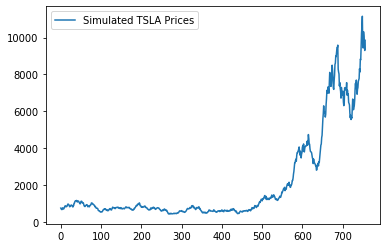

In [11]:
# Use the `plot` function to plot the trajectory of TSLA stock based on a (252 * 3) trading day simulation
simulated_price_df.plot()

### Calculate Daily Returns of Simulated Stock Prices for TSLA

In [12]:
# Use the `pct_change` function to calculate daily returns of simulated stock prices for TSLA
simulated_daily_returns = simulated_price_df.pct_change()
simulated_daily_returns.head()

,Simulated TSLA Prices
0,NaN
1,-0.062151
2,-0.037789
3,-0.008422
4,0.126569


### Calculate the Cumulative Returns of Simulated Stock Prices for TSLA

In [13]:
# Use the `cumprod` function to calculate the cumulative returns of simulated stock prices for TSLA
simulated_cumulative_returns = (1 + simulated_daily_returns).cumprod()
simulated_cumulative_returns.head()

,Simulated TSLA Prices
0,NaN
1,0.937849
2,0.902409
3,0.894809
4,1.008064


### Calculate the Cumulative Profits/Losses of Simulated Stock Prices for TSLA

In [14]:
# Multiply an initial investment by the cumulative returns of simulative stock prices to
# return the progression of cumulative returns in terms of money
initial_investment = 10000
cumulative_pnl = initial_investment * simulated_cumulative_returns
cumulative_pnl.head()

,Simulated TSLA Prices
0,NaN
1,9378.492340
2,9024.085499
3,8948.087473
4,10080.640318


### Plot the Cumulative Profits/Losses of `$10,000` in TSLA Over the Next 3 Years (252 * 3) of Trading Days

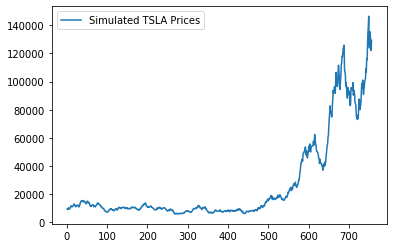

In [15]:
# Use the 'plot' function to create a chart of the cumulative profits/losses
cumulative_pnl.plot()